## Lấy dữ liệu

In [1]:
!cp -r /kaggle/input/stargan-face-ep4/stargan /kaggle/working/

%cd stargan

/kaggle/working/stargan


## Test cắt ảnh

In [2]:
%%capture
!pip install mediapipe rembg onnxruntime

In [3]:
import os

attr_file_path = '/kaggle/working/stargan/data/celeba/face_attr.txt'

# Xóa tệp nếu tồn tại
if os.path.exists(attr_file_path):
    os.remove(attr_file_path)
    print(f"Đã xóa tệp {attr_file_path}")
else:
    print(f"Tệp {attr_file_path} không tồn tại.")

# Các tiêu chí yêu cầu
attributes = [
    "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald", "Bangs", "Big_Lips", 
    "Big_Nose", "Black_Hair", "Blond_Hair", "Blurry", "Brown_Hair", "Bushy_Eyebrows", 
    "Chubby", "Double_Chin", "Eyeglasses", "Goatee", "Gray_Hair", "Heavy_Makeup", 
    "High_Cheekbones", "Male", "Mouth_Slightly_Open", "Mustache", "Narrow_Eyes", 
    "No_Beard", "Oval_Face", "Pale_Skin", "Pointy_Nose", "Receding_Hairline", 
    "Rosy_Cheeks", "Sideburns", "Smiling", "Straight_Hair", "Wavy_Hair", 
    "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace", 
    "Wearing_Necktie", "Young"
]

positive_attributes = ["Black_Hair", "Male", "Pale_Skin"]

with open(attr_file_path, 'w') as f:
    # Dòng đầu tiên: số ảnh 
    f.write("1\n")
    
    # Dòng thứ hai: các tiêu chí
    f.write("5_o_Clock_Shadow ")
    f.write(" ".join(attributes) + "\n")
    
    # Dòng thứ 3: chứa thông tin ảnh và giá trị
    values = ["1" if attr in positive_attributes else "-1" for attr in attributes]
    f.write(f"face_image.jpg " + " ".join(values) + "\n")

print(f"Đã tạo lại tệp {attr_file_path}.")

Tệp /kaggle/working/stargan/data/celeba/face_attr.txt không tồn tại.
Đã tạo lại tệp /kaggle/working/stargan/data/celeba/face_attr.txt.


In [4]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
from PIL import Image
from rembg import remove
import torch
import torchvision.transforms as T


# Load Mediapipe Face Detection cho việc phát hiện khuôn mặt
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

def detect_and_crop(image, expand_ratio=0.3):
    """
    Phát hiện khuôn mặt bằng Mediapipe và cắt riêng phần khuôn mặt và phần áo từ ảnh đầu vào.
    Hộp giới hạn khuôn mặt sẽ được mở rộng theo tỷ lệ expand_ratio.
    """
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Chuyển đổi ảnh sang RGB vì Mediapipe yêu cầu đầu vào RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            for detection in results.detections:
                # Lấy tọa độ hộp giới hạn của khuôn mặt
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                width = int(bboxC.width * w)
                height = int(bboxC.height * h)

                # Mở rộng hộp giới hạn khuôn mặt
                x_min_exp = max(0, x_min - int(width * expand_ratio))
                y_min_exp = max(0, y_min - int(height * expand_ratio))
                x_max_exp = min(w, x_min + width + int(width * expand_ratio))
                y_max_exp = min(h, y_min + height + int(height * expand_ratio))

                # Cắt vùng khuôn mặt mở rộng
                face_img = image[y_min_exp:y_max_exp, x_min_exp:x_max_exp]

                # Trả về tọa độ và ảnh cắt
                face_coords = (x_min_exp, y_min_exp, x_max_exp, y_max_exp)

                return face_img, face_coords

    return None, None

## Connect tele

In [5]:
# Hàm cắt ảnh thành từng phần
def split_image(image, num_parts=18, part_size=(156, 156)):
    height, width = image.shape[0], image.shape[1]
    parts = []
    for i in range(num_parts):
        x = (i % num_parts) * part_size[0]
        y = (i // num_parts) * part_size[1]
        part = image[y:y + part_size[1], x:x + part_size[0]]
        parts.append(part)
    return parts

In [6]:
def face_gan_model():
    # khuôn mặt
    !python /kaggle/working/stargan/main.py --mode test --dataset CelebA --image_size 156 --c_dim 17 \
                     --selected_attrs Bald Bangs Black_Hair Blond_Hair Chubby Eyeglasses Goatee Gray_Hair Heavy_Makeup Male Mouth_Slightly_Open Mustache No_Beard Pale_Skin Rosy_Cheeks Smiling Wearing_Lipstick \
                     --model_save_dir='/kaggle/working/stargan/stargan_celeba/models' \
                     --result_dir='/kaggle/working/stargan/stargan_celeba/results'  \
                     --attr_path='/kaggle/working/stargan/data/celeba/face_attr.txt'  \
                     --celeba_image_dir='/kaggle/working/stargan/data/celeba/img/'  \
                     --test_iters='550000'
    
    
    # Đường dẫn đến ảnh
    image_path = '/kaggle/working/stargan/stargan_celeba/results/1-images.jpg'

    # Đọc ảnh
    image = cv2.imread(image_path)

    # Cắt ảnh thành 18 phần
    image_parts = split_image(image, num_parts=18)

    generated_images = image_parts[0:]  # Ảnh sinh ra

    return generated_images

In [7]:
%%capture
!pip install opencv-python opencv-python-headless

In [8]:
def remove_background(image):
    """Xóa nền trắng của ảnh"""
    # Chuyển ảnh sang không gian màu HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Định nghĩa khoảng màu trắng trong không gian màu HSV
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([255, 255, 255])

    # Tạo mặt nạ cho các pixel trắng
    mask = cv2.inRange(hsv, lower_white, upper_white)

    # Tạo ảnh kết quả với nền trong suốt
    result = image.copy()

    # Chuyển đổi ảnh sang BGRA (4 kênh) để có thể sử dụng alpha channel (nền trong suốt)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)

    # Gán alpha channel cho các pixel trắng là 0 (trong suốt)
    result[:, :, 3] = np.where(mask == 255, 0, 255)

    return result

In [9]:
def find_face_coordinates(original_image, cropped_image):
    # Chuyển ảnh sang dạng grayscale
    gray_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    gray_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    # Sử dụng ORB để phát hiện các điểm đặc trưng
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(gray_original, None)
    kp2, des2 = orb.detectAndCompute(gray_cropped, None)

    # Khớp các điểm đặc trưng giữa ảnh gốc và ảnh cắt
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Sắp xếp các match theo khoảng cách
    matches = sorted(matches, key=lambda x: x.distance)

    # Lấy tọa độ các điểm đã khớp
    points_original = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points_cropped = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Tính toán ma trận phép biến đổi (Homography) giữa ảnh gốc và ảnh cắt
    matrix, mask = cv2.findHomography(points_cropped, points_original, cv2.RANSAC, 5.0)

    # Tìm ra tọa độ của ảnh cắt trong ảnh gốc
    h, w = cropped_image.shape[:2]
    corners_cropped = np.float32([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]]).reshape(-1, 1, 2)
    corners_original = cv2.perspectiveTransform(corners_cropped, matrix)

    # Lấy tọa độ góc trái trên và góc phải dưới của phần cắt trong ảnh gốc
    x1, y1 = np.int32(corners_original[0][0])  # Tọa độ góc trái trên (đảm bảo là int)
    x2, y2 = np.int32(corners_original[2][0])  # Tọa độ góc phải dưới (đảm bảo là int)

    # Kiểm tra xem tọa độ có hợp lệ không
    if x1 < 0: x1 = 0
    if y1 < 0: y1 = 0
    if x2 >= original_image.shape[1]: x2 = original_image.shape[1] - 1
    if y2 >= original_image.shape[0]: y2 = original_image.shape[0] - 1

    return (x1, y1), (x2, y2)

def overlay_face_on_original(original_image, cropped_image, face_coords):
    # Lấy tọa độ góc trái trên và góc phải dưới của phần cắt trong ảnh gốc
    (x1, y1), (x2, y2) = face_coords

    # Resize ảnh cắt sao cho nó vừa với vùng cần ghép trong ảnh gốc
    target_width = x2 - x1
    target_height = y2 - y1
    resized_cropped_image = cv2.resize(cropped_image, (target_width, target_height))

    # Ghi đè ảnh cắt lên ảnh gốc
    original_image_with_overlay = original_image.copy()
    original_image_with_overlay[y1:y1 + resized_cropped_image.shape[0], x1:x1 + resized_cropped_image.shape[1]] = resized_cropped_image

    return original_image_with_overlay


In [10]:
# Hàm gen_img giả định (xử lý ảnh)
def gen_img(image_path):
    # Đọc ảnh bằng OpenCV
    input_image = cv2.imread(image_path)

    # Phát hiện và cắt khuôn mặt và quần áo từ ảnh đầu vào
    expand_ratio=0.5
    face_image, face_coords = detect_and_crop(input_image, expand_ratio)

    if face_image is not None:

        # Lưu ảnh khuôn mặt và quần áo vào các thư mục tương ứng
        face_save_path = '/kaggle/working/stargan/data/celeba/img/face_image.jpg'

        # Kiểm tra và tạo thư mục nếu chưa tồn tại
        os.makedirs(os.path.dirname(face_save_path), exist_ok=True)
        
        # Hiển thị kết quả đã cắt
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
        plt.title("Ảnh gốc")

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB))
        plt.title("Khuôn mặt đã cắt")

        face_image = cv2.resize(face_image, (178, 218))

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB))
        plt.title("Khuôn mặt resize")
        
        plt.show()

        # Lưu ảnh
        cv2.imwrite(face_save_path, face_image)        

        face_result = face_gan_model()

        for i in range(len(face_result)):
            try:
                img = Image.fromarray(face_result[i])
                
                resized_img = img.resize((720, 720))
                
                face_result[i] = np.array(resized_img)
            except Exception as e:
                print(f"Không thể resize ảnh thứ {i}: {e}")

        #################
        ### tạo lại ảnh với nền của ảnh cũ 
        input_image = remove_background(input_image)
        for i in range(len(face_result)):
            face_result[i] = remove_background(face_result[i])
    
        face_coords = find_face_coordinates(input_image, face_result[0])

        for i in range(len(face_result)):
            face_result[i] = overlay_face_on_original(input_image, face_result[i], face_coords)

        for i in range(len(face_result)):
            face_result[i] = remove_background(face_result[i])
        
        print("Đã tạo ảnh.\n\n\n")
    else:
        print("Không phát hiện được khuôn mặt hoặc quần áo trong ảnh.")
    
    return face_result[1:]

In [11]:
%%capture
!pip install python-telegram-bot

In [12]:
# 17 tiêu chí
criteria_names = [
    "Hói Đầu",               # Bald
    "Tóc Mái",               # Bangs
    "Tóc Đen",               # Black Hair
    "Tóc Vàng",              # Blond Hair
    "Mũm Mĩm",               # Chubby
    "Đeo Kính",              # Eyeglasses
    "Râu Dê",                # Goatee
    "Tóc Bạc",               # Gray Hair
    "Trang Điểm Đậm",        # Heavy Makeup
    "Nam Giới",              # Male
    "Miệng Hơi Mở",          # Mouth Slightly Open
    "Râu Mép",               # Mustache
    "Không Râu",             # No Beard
    "Da Nhợt Nhạt",          # Pale Skin
    "Má Hồng",               # Rosy Cheeks
    "Mỉm Cười",              # Smiling
    "Đánh Son"               # Wearing Lipstick
]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1765127548.542384     118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


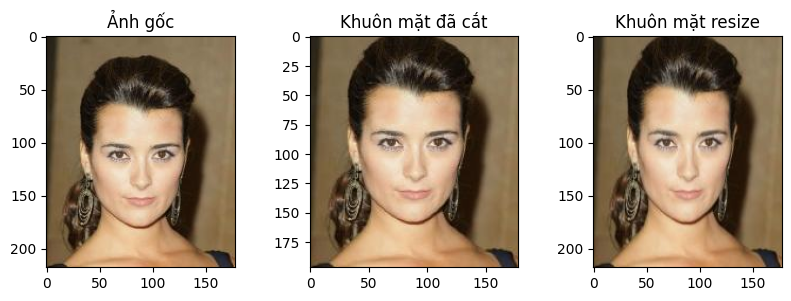

Namespace(c_dim=17, c2_dim=8, celeba_crop_size=178, rafd_crop_size=256, image_size=156, g_conv_dim=64, d_conv_dim=64, g_repeat_num=6, d_repeat_num=6, lambda_cls=1, lambda_rec=10, lambda_gp=10, dataset='CelebA', batch_size=16, num_iters=200000, num_iters_decay=100000, g_lr=0.0001, d_lr=0.0001, n_critic=5, beta1=0.5, beta2=0.999, resume_iters=None, selected_attrs=['Bald', 'Bangs', 'Black_Hair', 'Blond_Hair', 'Chubby', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Pale_Skin', 'Rosy_Cheeks', 'Smiling', 'Wearing_Lipstick'], test_iters=550000, num_workers=1, mode='test', use_tensorboard=True, celeba_image_dir='/kaggle/working/stargan/data/celeba/img/', attr_path='/kaggle/working/stargan/data/celeba/face_attr.txt', rafd_image_dir='data/RaFD/train', log_dir='stargan/logs', model_save_dir='/kaggle/working/stargan/stargan_celeba/models', sample_dir='stargan/samples', result_dir='/kaggle/working/stargan/stargan_celeba/results', log_st

In [ ]:
import asyncio
from telegram import Update, InputMediaPhoto, InlineKeyboardMarkup, InlineKeyboardButton
from telegram.ext import (
    Application, CommandHandler, MessageHandler,
    filters, ContextTypes, CallbackQueryHandler
)
from PIL import Image
import io
import cv2

# /start
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    await update.message.reply_text(
        "Xin chào, tôi có thể chỉnh sửa thuộc tính trên khuôn mặt như thêm râu, thêm kính, ..."
    )


# Nhận ảnh từ người dùng
async def handle_photo(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    try:
        photo = update.message.photo[-1]
        file = await context.bot.get_file(photo.file_id)

        photo_bytes = await file.download_as_bytearray()
        image = Image.open(io.BytesIO(photo_bytes)).convert("RGB")
        image.save("user_image.jpg")

        await update.message.reply_text("Cảm ơn! Ảnh đã được nhận. Đang xử lý...")

        # GEN 17 ẢNH
        result_images = gen_img("user_image.jpg")
        if not result_images or len(result_images) != 17:
            await update.message.reply_text("Lỗi: Không tạo đủ 17 ảnh.")
            return

        # LƯU kết quả vào user_data để callback lấy ra
        context.user_data["generated_images"] = result_images

        # Gửi menu 17 nút chọn thuộc tính
        keyboard = [
            [InlineKeyboardButton(name, callback_data=f"attr_{i}")]
            for i, name in enumerate(criteria_names)
        ]
        markup = InlineKeyboardMarkup(keyboard)

        await update.message.reply_text(
            "Chọn thuộc tính bạn muốn áp dụng:",
            reply_markup=markup
        )

    except Exception as e:
        await update.message.reply_text(f"Lỗi xử lý ảnh: {str(e)}")


# Callback xử lý chọn thuộc tính
async def choose_attribute(update: Update, context: ContextTypes.DEFAULT_TYPE):
    query = update.callback_query
    await query.answer()

    try:
        idx = int(query.data.replace("attr_", ""))

        images = context.user_data.get("generated_images")
        if images is None:
            await query.edit_message_text("Không tìm thấy ảnh đã gen. Hãy gửi ảnh lại.")
            return

        selected_img = images[idx]

        _, buffer = cv2.imencode(".jpg", selected_img)
        img_bytes = buffer.tobytes()

        await query.message.reply_photo(
            photo=img_bytes,
            caption=f"Ảnh với thuộc tính: {criteria_names[idx]}"
        )

    except Exception as e:
        await query.edit_message_text(f"Lỗi xử lý chọn thuộc tính: {e}")


# Nhận text
async def handle_text(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    await update.message.reply_text("Hãy gửi ảnh khuôn mặt.")


# MAIN BOT
async def main():
    TOKEN = "7804908185:AAEImfvzTEmSrL_No1HWkU2DByou99gy-KU"
    app = Application.builder().token(TOKEN).build()

    app.add_handler(CommandHandler("start", start))
    app.add_handler(MessageHandler(filters.PHOTO, handle_photo))
    app.add_handler(CallbackQueryHandler(choose_attribute, pattern=r"attr_"))
    app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_text))

    await app.run_polling()


if __name__ == "__main__":
    import nest_asyncio
    nest_asyncio.apply()
    asyncio.run(main())
